# Trading Strategies powered by Machine Learning - Logistic Regression

## Logistic Regression with scikit-learn - a Simple Introduction

In [16]:
import sys
sys.path.append('../../')

In [17]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [19]:
from backtesting import Strategy

## Getting the Data

In [20]:
XAUUSD = load_data()

In [21]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [22]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


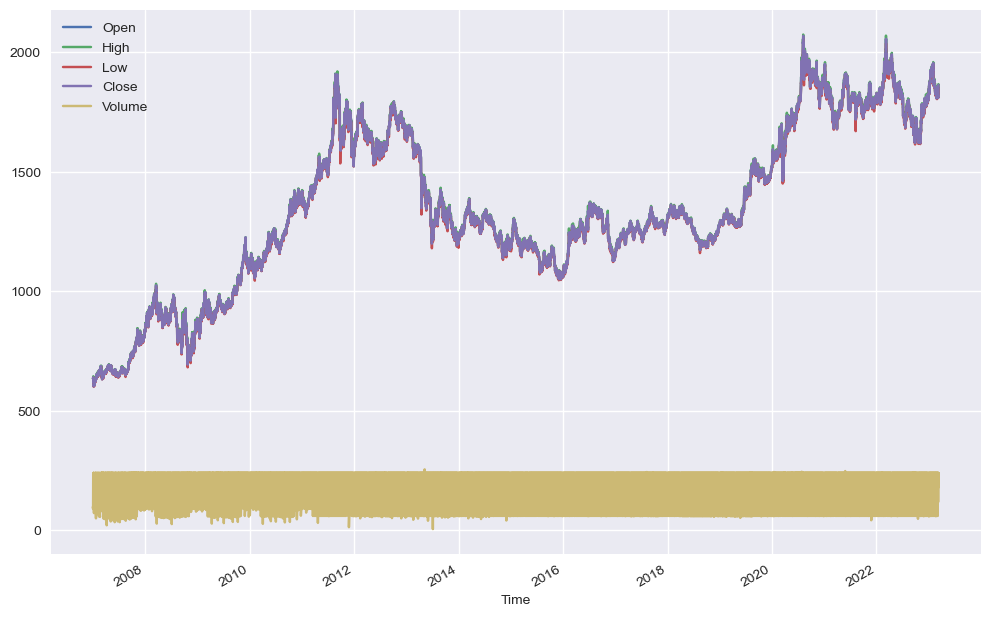

In [23]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [24]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            if self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [25]:
strategy = Logistic_Regression
account_size = 200000
folder_ML_Strategy = 'Logistic Regression'

In [26]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["direction"] = np.sign(data.returns)
        data.dropna(inplace=True)
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
        lm.fit(data[cols], data['direction'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=20000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        
        self.Predict()
        result_test = self.Backtest(self.data_test)
        

        return result_train, result_test

## TF D1

In [27]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [28]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [29]:
train , test = ml.Run()

### In-Sample Backtesting

In [30]:
train

Start                     2007-01-08 00:00:00
End                       2020-12-31 00:00:00
Duration                   5106 days 00:00:00
Exposure Time [%]                   99.954107
Equity Final [$]                    21799.483
Equity Peak [$]                     21812.753
Return [%]                           8.997415
Buy & Hold Return [%]              211.556943
Return (Ann.) [%]                    0.499426
Volatility (Ann.) [%]                0.969927
Sharpe Ratio                         0.514911
Sortino Ratio                        0.728113
Calmar Ratio                         0.163972
Max. Drawdown [%]                   -3.045792
Avg. Drawdown [%]                    -0.18319
Max. Drawdown Duration     3078 days 00:00:00
Avg. Drawdown Duration       56 days 00:00:00
# Trades                                  491
Win Rate [%]                        57.841141
Best Trade [%]                      11.891658
Worst Trade [%]                     -20.61903
Avg. Trade [%]                    

In [31]:
train

Start                     2007-01-08 00:00:00
End                       2020-12-31 00:00:00
Duration                   5106 days 00:00:00
Exposure Time [%]                   99.954107
Equity Final [$]                    21799.483
Equity Peak [$]                     21812.753
Return [%]                           8.997415
Buy & Hold Return [%]              211.556943
Return (Ann.) [%]                    0.499426
Volatility (Ann.) [%]                0.969927
Sharpe Ratio                         0.514911
Sortino Ratio                        0.728113
Calmar Ratio                         0.163972
Max. Drawdown [%]                   -3.045792
Avg. Drawdown [%]                    -0.18319
Max. Drawdown Duration     3078 days 00:00:00
Avg. Drawdown Duration       56 days 00:00:00
# Trades                                  491
Win Rate [%]                        57.841141
Best Trade [%]                      11.891658
Worst Trade [%]                     -20.61903
Avg. Trade [%]                    

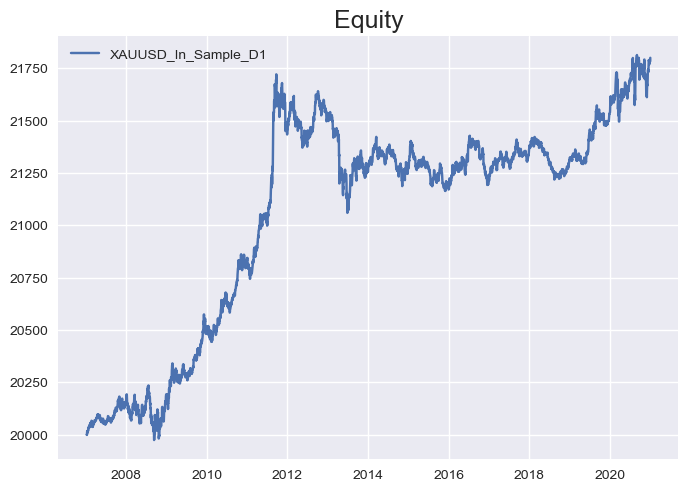

In [32]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [33]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                    20380.759
Equity Peak [$]                     20502.316
Return [%]                           1.903795
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                     0.48365
Volatility (Ann.) [%]                1.313868
Sharpe Ratio                         0.368111
Sortino Ratio                        0.499393
Calmar Ratio                          0.31846
Max. Drawdown [%]                   -1.518716
Avg. Drawdown [%]                    -0.38326
Max. Drawdown Duration      311 days 00:00:00
Avg. Drawdown Duration       49 days 00:00:00
# Trades                                   97
Win Rate [%]                        58.762887
Best Trade [%]                       8.072033
Worst Trade [%]                      -9.33197
Avg. Trade [%]                    

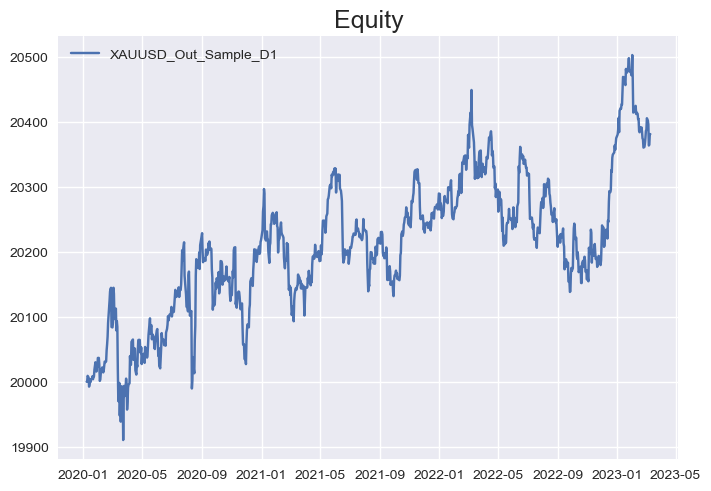

In [34]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [35]:
filename_train = f'result_{TF}_In_Sample.csv'

In [36]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [37]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [38]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [39]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [40]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [41]:
train , test = ml.Run()

### In-Sample Backtesting

In [42]:
train

Start                     2007-01-02 00:00:00
End                       2020-12-31 20:00:00
Duration                   5112 days 20:00:00
Exposure Time [%]                   99.991099
Equity Final [$]                    19731.798
Equity Peak [$]                     20477.963
Return [%]                           -1.34101
Buy & Hold Return [%]              197.773172
Return (Ann.) [%]                    -0.07807
Volatility (Ann.) [%]                1.029157
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.330829
Avg. Drawdown [%]                    -0.19174
Max. Drawdown Duration     3432 days 00:00:00
Avg. Drawdown Duration       57 days 06:00:00
# Trades                                 5662
Win Rate [%]                        54.274108
Best Trade [%]                        5.73108
Worst Trade [%]                     -7.714997
Avg. Trade [%]                    

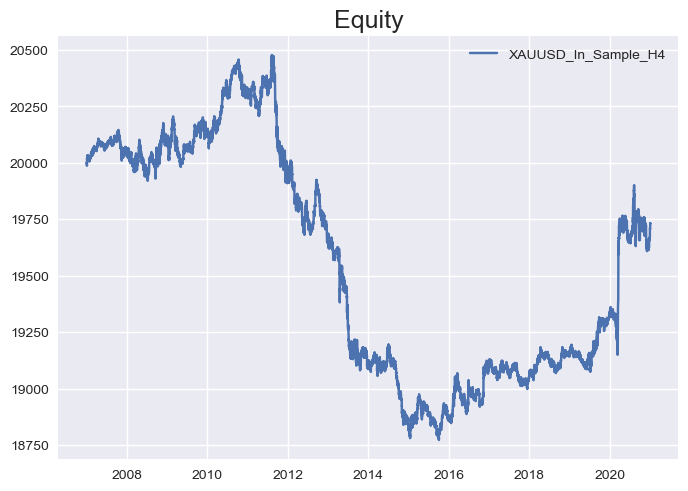

In [43]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [44]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                    20369.264
Equity Peak [$]                     20611.242
Return [%]                            1.84632
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                    0.466772
Volatility (Ann.) [%]                1.353664
Sharpe Ratio                         0.344821
Sortino Ratio                        0.501766
Calmar Ratio                          0.19412
Max. Drawdown [%]                   -2.404556
Avg. Drawdown [%]                   -0.269836
Max. Drawdown Duration      567 days 12:00:00
Avg. Drawdown Duration       41 days 06:00:00
# Trades                                 1295
Win Rate [%]                        56.525097
Best Trade [%]                       5.572428
Worst Trade [%]                     -4.467755
Avg. Trade [%]                    

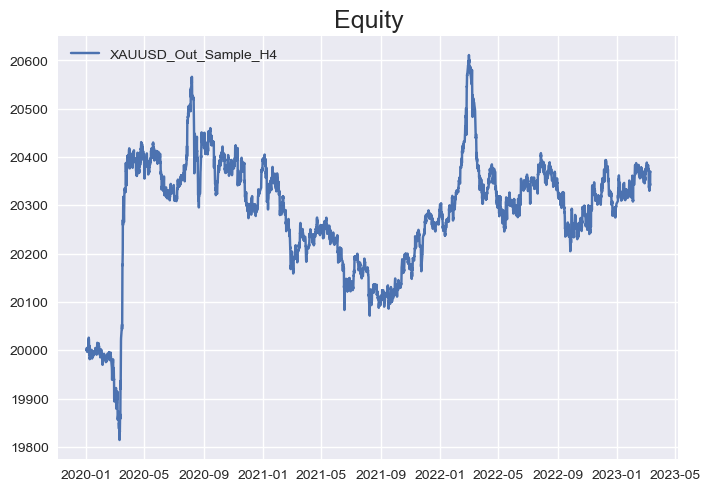

In [45]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [46]:
filename_train = f'result_{TF}_In_Sample.csv'

In [47]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [48]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [49]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [50]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [51]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [52]:
train , test = ml.Run()

### In-Sample Backtesting

In [53]:
train

Start                     2007-01-01 06:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 15:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                    19809.444
Equity Peak [$]                     20830.165
Return [%]                           -0.95278
Buy & Hold Return [%]              198.538115
Return (Ann.) [%]                   -0.055473
Volatility (Ann.) [%]                0.942639
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -5.249805
Avg. Drawdown [%]                   -0.079074
Max. Drawdown Duration     3307 days 20:00:00
Avg. Drawdown Duration       20 days 12:00:00
# Trades                                30314
Win Rate [%]                        53.747443
Best Trade [%]                       5.019552
Worst Trade [%]                     -7.346315
Avg. Trade [%]                    

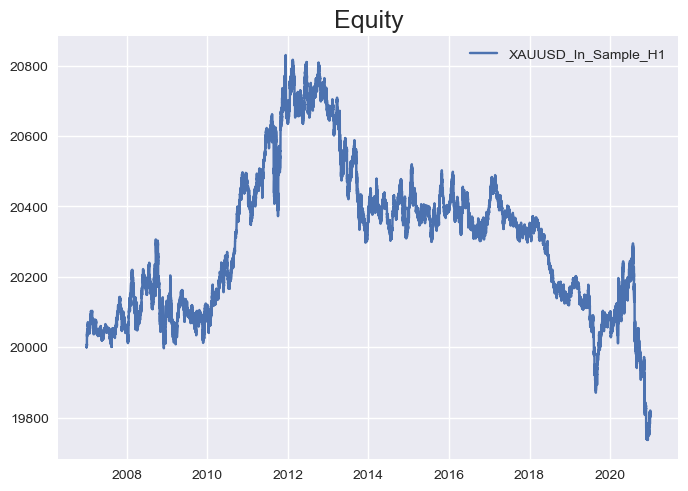

In [54]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [55]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                    20138.057
Equity Peak [$]                     20196.763
Return [%]                           0.690285
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                    0.176708
Volatility (Ann.) [%]                1.242072
Sharpe Ratio                         0.142269
Sortino Ratio                        0.194663
Calmar Ratio                         0.061536
Max. Drawdown [%]                   -2.871643
Avg. Drawdown [%]                   -0.199048
Max. Drawdown Duration      956 days 00:00:00
Avg. Drawdown Duration       31 days 10:00:00
# Trades                                 6694
Win Rate [%]                        54.391993
Best Trade [%]                       3.223874
Worst Trade [%]                     -5.475604
Avg. Trade [%]                    

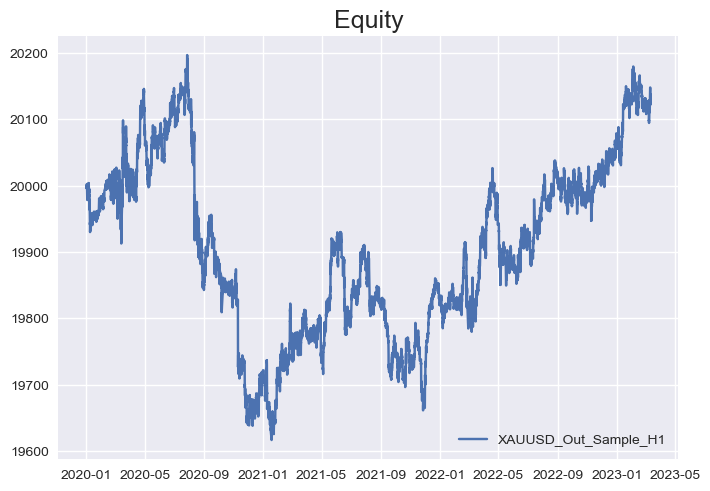

In [56]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [57]:
filename_train = f'result_{TF}_In_Sample.csv'

In [58]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [59]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [60]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [61]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [62]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [63]:
train , test = ml.Run()

### In-Sample Backtesting

In [64]:
train

Start                     2007-01-01 03:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 18:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                    22433.019
Equity Peak [$]                     22489.691
Return [%]                          12.165095
Buy & Hold Return [%]              198.631601
Return (Ann.) [%]                    0.665659
Volatility (Ann.) [%]                0.900495
Sharpe Ratio                         0.739214
Sortino Ratio                        1.055938
Calmar Ratio                         0.313714
Max. Drawdown [%]                   -2.121863
Avg. Drawdown [%]                   -0.039975
Max. Drawdown Duration     1056 days 04:30:00
Avg. Drawdown Duration        4 days 23:04:00
# Trades                                59730
Win Rate [%]                        54.964005
Best Trade [%]                       4.102281
Worst Trade [%]                     -6.424413
Avg. Trade [%]                    

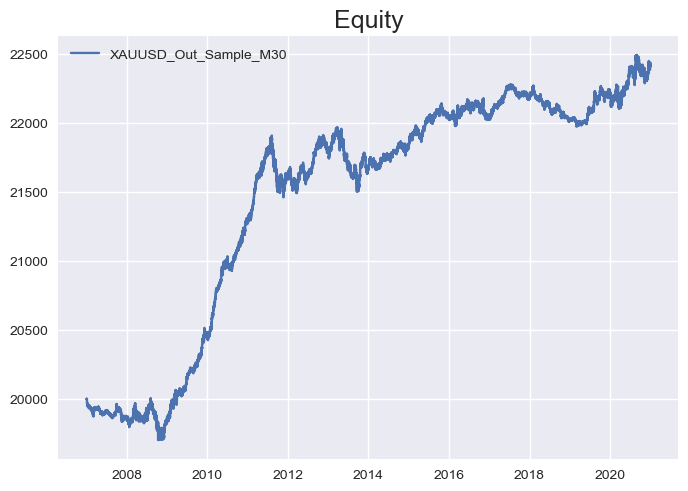

In [65]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [66]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                    20508.723
Equity Peak [$]                     20622.356
Return [%]                           2.543615
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                    0.649753
Volatility (Ann.) [%]                1.216974
Sharpe Ratio                         0.533908
Sortino Ratio                        0.767037
Calmar Ratio                         0.494125
Max. Drawdown [%]                   -1.314956
Avg. Drawdown [%]                   -0.082452
Max. Drawdown Duration      541 days 13:00:00
Avg. Drawdown Duration        7 days 21:22:00
# Trades                                13331
Win Rate [%]                        54.752082
Best Trade [%]                       2.817031
Worst Trade [%]                     -4.759791
Avg. Trade [%]                    

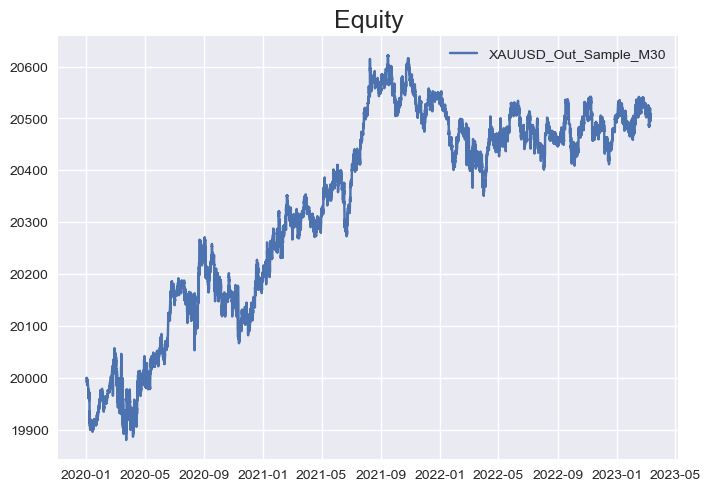

In [67]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [68]:
filename_train = f'result_{TF}_In_Sample.csv'

In [69]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [70]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [71]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [72]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [73]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [74]:
train , test = ml.Run()

### In-Sample Backtesting

In [75]:
train

Start                     2014-09-23 14:30:00
End                       2020-12-31 21:45:00
Duration                   2291 days 07:15:00
Exposure Time [%]                   99.998651
Equity Final [$]                    20802.566
Equity Peak [$]                     20923.934
Return [%]                            4.01283
Buy & Hold Return [%]                55.35929
Return (Ann.) [%]                    0.504361
Volatility (Ann.) [%]                0.878447
Sharpe Ratio                          0.57415
Sortino Ratio                        0.815724
Calmar Ratio                         0.287214
Max. Drawdown [%]                   -1.756047
Avg. Drawdown [%]                   -0.041803
Max. Drawdown Duration      922 days 05:00:00
Avg. Drawdown Duration        5 days 04:30:00
# Trades                                52123
Win Rate [%]                        54.885559
Best Trade [%]                       2.599856
Worst Trade [%]                     -4.883636
Avg. Trade [%]                    

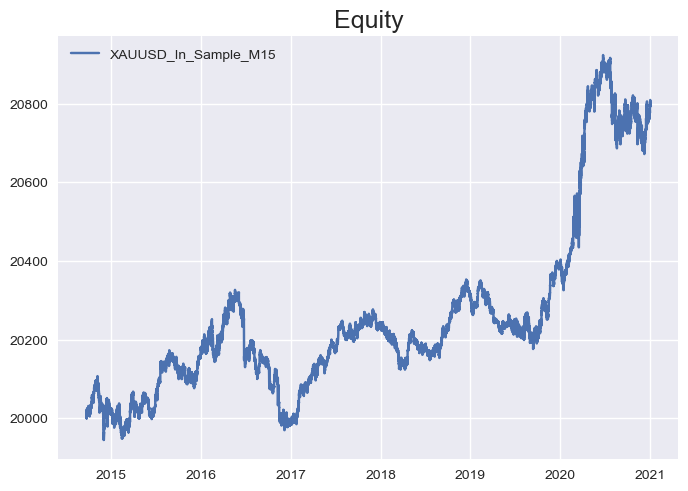

In [76]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [77]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                    21049.279
Equity Peak [$]                     21248.853
Return [%]                           5.246395
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                    1.309656
Volatility (Ann.) [%]                 1.23775
Sharpe Ratio                         1.058095
Sortino Ratio                        1.554021
Calmar Ratio                         0.707747
Max. Drawdown [%]                   -1.850458
Avg. Drawdown [%]                   -0.046331
Max. Drawdown Duration      296 days 07:00:00
Avg. Drawdown Duration        2 days 08:59:00
# Trades                                26338
Win Rate [%]                        54.844711
Best Trade [%]                       1.866556
Worst Trade [%]                     -4.883636
Avg. Trade [%]                    

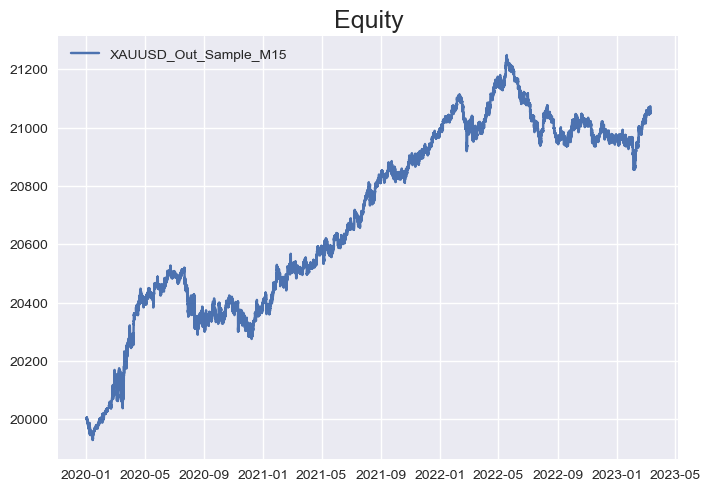

In [78]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [79]:
filename_train = f'result_{TF}_In_Sample.csv'

In [80]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [81]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [82]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [83]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [84]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [85]:
train , test = ml.Run()

### In-Sample Backtesting

In [86]:
train

Start                     2020-05-15 11:40:00
End                       2023-03-10 17:55:00
Duration                   1029 days 06:15:00
Exposure Time [%]                      99.999
Equity Final [$]                    21157.161
Equity Peak [$]                     21192.994
Return [%]                           5.785805
Buy & Hold Return [%]                   7.591
Return (Ann.) [%]                    1.656616
Volatility (Ann.) [%]                1.204952
Sharpe Ratio                          1.37484
Sortino Ratio                         2.06632
Calmar Ratio                         0.984113
Max. Drawdown [%]                    -1.68336
Avg. Drawdown [%]                   -0.023605
Max. Drawdown Duration      524 days 20:40:00
Avg. Drawdown Duration        1 days 02:58:00
# Trades                                82301
Win Rate [%]                        53.389388
Best Trade [%]                       1.030794
Worst Trade [%]                     -4.158866
Avg. Trade [%]                    

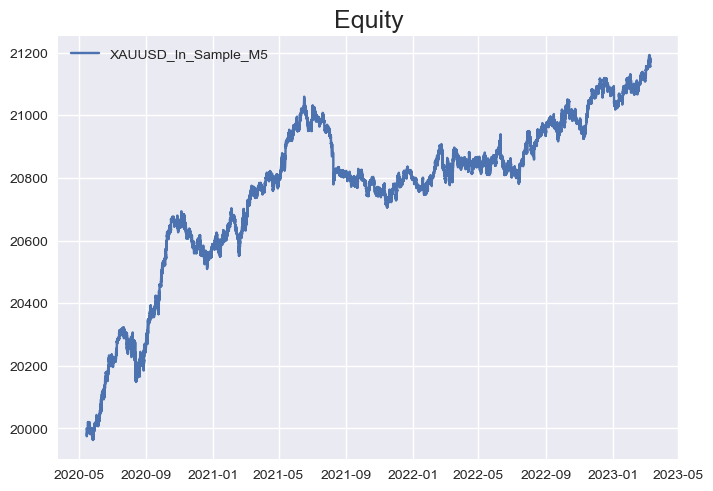

In [87]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [88]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                    20067.482
Equity Peak [$]                     20103.315
Return [%]                            0.33741
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                    1.481186
Volatility (Ann.) [%]                1.106973
Sharpe Ratio                         1.338051
Sortino Ratio                         1.98561
Calmar Ratio                         3.926762
Max. Drawdown [%]                   -0.377203
Avg. Drawdown [%]                   -0.024063
Max. Drawdown Duration       21 days 10:25:00
Avg. Drawdown Duration        0 days 16:06:00
# Trades                                 5464
Win Rate [%]                        53.971449
Best Trade [%]                       0.722786
Worst Trade [%]                     -1.768975
Avg. Trade [%]                    

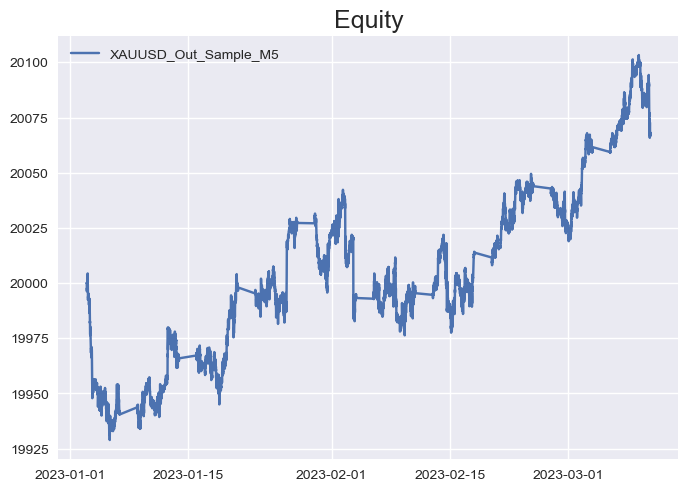

In [89]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [90]:
filename_train = f'result_{TF}_In_Sample.csv'

In [91]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [92]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [93]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [94]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [95]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [96]:
train , test = ml.Run()

### In-Sample Backtesting

In [97]:
train

Start                     2022-08-16 23:19:00
End                       2023-03-10 17:59:00
Duration                    205 days 18:40:00
Exposure Time [%]                      99.999
Equity Final [$]                      20805.6
Equity Peak [$]                     20818.357
Return [%]                              4.028
Buy & Hold Return [%]                4.985419
Return (Ann.) [%]                    5.811524
Volatility (Ann.) [%]                1.270234
Sharpe Ratio                          4.57516
Sortino Ratio                         8.94059
Calmar Ratio                         8.111667
Max. Drawdown [%]                    -0.71644
Avg. Drawdown [%]                   -0.010181
Max. Drawdown Duration       43 days 22:55:00
Avg. Drawdown Duration        0 days 03:43:00
# Trades                                62431
Win Rate [%]                        55.187327
Best Trade [%]                       0.973243
Worst Trade [%]                     -1.352407
Avg. Trade [%]                    

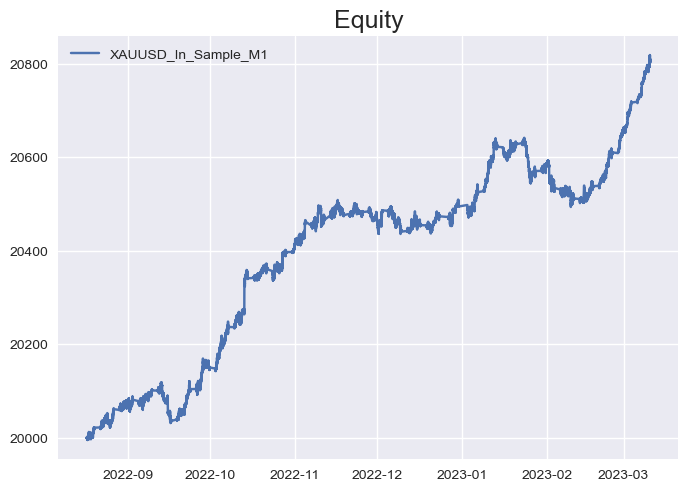

In [98]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [99]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                    20311.519
Equity Peak [$]                     20324.276
Return [%]                           1.557595
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                    6.907627
Volatility (Ann.) [%]                1.434156
Sharpe Ratio                         4.816509
Sortino Ratio                        8.372409
Calmar Ratio                         9.410813
Max. Drawdown [%]                    -0.73401
Avg. Drawdown [%]                   -0.008772
Max. Drawdown Duration       35 days 01:07:00
Avg. Drawdown Duration        0 days 02:54:00
# Trades                                20858
Win Rate [%]                        55.379231
Best Trade [%]                       0.708517
Worst Trade [%]                     -1.115095
Avg. Trade [%]                    

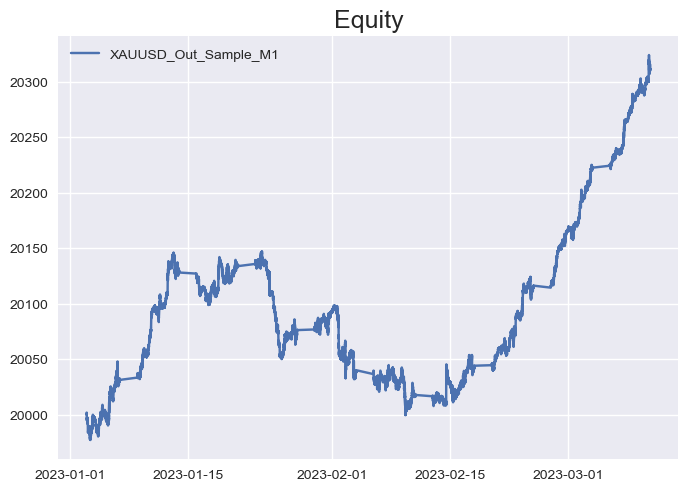

In [100]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [101]:
filename_train = f'result_{TF}_In_Sample.csv'

In [102]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')